In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
import glob as gb
from functools import reduce
from scipy.optimize import curve_fit

In [2]:
## Canvas parameters

# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 9 and height to 6
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

In [3]:
## Getting data from files of OS and ESA

OS1 = [file for file in gb.glob("ALL0002/*CH3.CSV")] # Cavity
OS2 = [file for file in gb.glob("ALL0003/*CH1.CSV")] # PZT
OS3 = [file for file in gb.glob("ALL0003/*CH3.CSV")] # Peaks

filesOS = [x for y in [OS1, OS2, OS3] for x in y] # Flat list

col_namesOS = [ ['t','DC1'],
                ['t','DC2'],
                ['t','DC3']]

#OS Tektronix
data_OSs = [pd.read_csv(trace, sep=',', usecols=[3,4], 
                        header=None, names=cols)
               for trace,cols in zip(filesOS, col_namesOS)]


data_cav = data_OSs[0]
data_cav2 = reduce(lambda x,y: pd.merge(x,y, on='t'), (data_OSs[1], data_OSs[2]))
cav = data_cav.copy()
cav2 = data_cav2.copy()

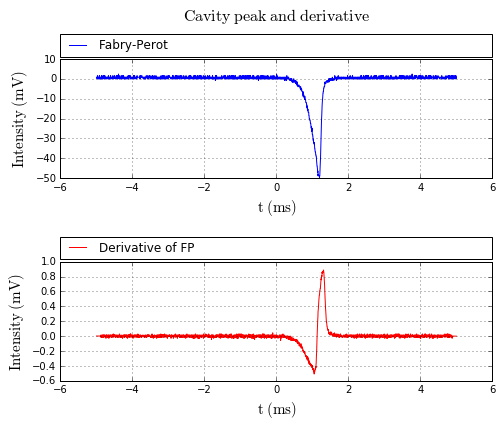

In [4]:
## Plot setup

f = plt.figure()
plt.subplots_adjust(top = 0.87, hspace=0.7, left  = 0.15)

#labelDC = {'DC1': "DC 1", 'DC2': "DC 2"}

data_cav = cav*1E3 # Getting backup and changing to mV and ms

## Plot A
ax1 = plt.subplot(211)
plt.plot(data_cav.t, data_cav.DC1)

#Lines and legends of ax1
h1, l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, ['Fabry-Perot'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, 
           mode="expand", borderaxespad=0.)

ax1.set_title(r"$\mathrm{Cavity\; peak\; and\; derivative}$", y=1.28, size=16)
ax1.set_xlabel(r'$\mathrm{t\; (ms)}$', size=15)
ax1.set_ylabel(r'$\mathrm{Intensity\;(mV)}$', size=15)
ax1.grid(True)

## Plot B
ax2 = plt.subplot(212, sharex=ax1)

# Applying Savitzky-Golay filter 
y1_= savgol_filter(data_cav.DC1, 55, 1)
data_cav.DC1 = y1_

plt.plot(data_cav.t, data_cav.diff().DC1, color = 'r')

#Lines and legends of ax2
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h2, ['Derivative of FP'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, 
           mode="expand", borderaxespad=0.)

ax2.set_xlabel(r'$\mathrm{t\; (ms)}$', size=15)
ax2.set_ylabel(r'$\mathrm{Intensity\;(mV)}$', size=15)
ax2.grid(True)

In [5]:
data_cav = cav*1E3 # Getting backup and changing to mV and ms

df_t = data_cav.copy() # Working with copies of the original
df1 = df_t.diff() # dy on every column
 
# Time derivative
df_t.DC1 = df1.DC1/df_t.t

left_df_t = df_t[(df_t.t >= 0.84) & (df_t.t <= 1.02)]
right_df_t = df_t[(df_t.t >= 1.24) & (df_t.t <= 1.29)]
print ('Left side-of-fringe derivative = {:.3e}'.format(left_df_t.mean().DC1), 'V/s')
print ('Right side-of-fringe derivative = {:.3e}'.format(right_df_t.mean().DC1), 'V/s')

Left side-of-fringe derivative = -4.097e-01 V/s
Right side-of-fringe derivative = 1.418e+00 V/s


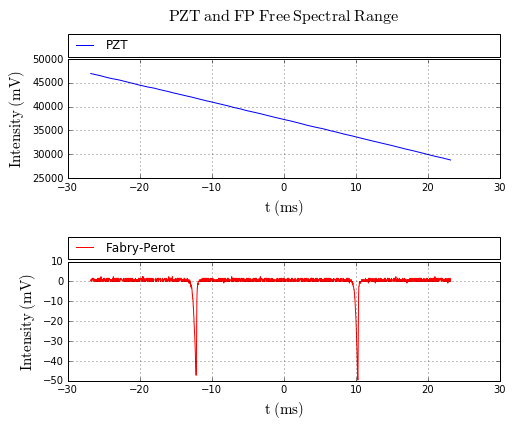

In [11]:
## Plot setup

f = plt.figure()
plt.subplots_adjust(top = 0.87, hspace=0.7, left=0.15)

#labelDC = {'DC1': "DC 1", 'DC2': "DC 2"}

# Important for plots and calculations
data_cav2 = cav2*1E3 # Getting backup and changing to mV and ms
data_cav2.DC2 = data_cav2.DC2*10 # Correcting PZT values (monitor controller)

## Plot A
ax1 = plt.subplot(211)

# Applying Savitzky-Golay filter 
y2_= savgol_filter(data_cav2.DC2, 55, 1)
data_cav2.DC2 = y2_

plt.plot(data_cav2.t, data_cav2.DC2)

#Lines and legends of ax1
h1, l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, ['PZT'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, 
           mode="expand", borderaxespad=0.)

ax1.set_title(r"$\mathrm{PZT\; and\; FP\; Free\; Spectral\; Range}$", y=1.28, size=16)
ax1.set_xlabel(r'$\mathrm{t\; (ms)}$', size=15)
ax1.set_ylabel(r'$\mathrm{Intensity\;(mV)}$', size=15)
ax1.grid(True)

## Plot B
ax2 = plt.subplot(212, sharex=ax1)

# Applying Savitzky-Golay filter 
#y3_= savgol_filter(data_cav2.DC3, 55, 1)
#data_cav2.DC2 = y3_

plt.plot(data_cav2.t, data_cav2.DC3, color = 'r')

#Lines and legends of ax2
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h2, ['Fabry-Perot'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, 
           mode="expand", borderaxespad=0.)

ax2.set_xlabel(r'$\mathrm{t\; (ms)}$', size=15)
ax2.set_ylabel(r'$\mathrm{Intensity\;(mV)}$', size=15)
ax2.grid(True)

In [14]:
## Frequency - time relation

data_cav2 = cav2*1E3 # Getting backup and changing to mV and ms
data_cav2.DC2 = data_cav2.DC2*10 # Correcting PZT values

# Smoothing dataset
y2_= savgol_filter(data_cav2.DC2, 55, 1)
data_cav2.DC2 = y2_

left_peak = data_cav2[(data_cav2.t >= -20) & (data_cav2.t <= 0)].copy()
right_peak = data_cav2[(data_cav2.t >= 0) & (data_cav2.t <= 20)].copy()

# Minima indexes 
a = left_peak.DC3.idxmin()
b = right_peak.DC3.idxmin()
dist_t = abs(right_peak.t[b] - left_peak.t[a]) # ms

FSR = 1.5E+9 # 1.5 GHz (Thorlabs)
print ('Distance between peaks = {}'.format(dist_t), 'ms')
freq_time = FSR / ((right_peak.t[b] - left_peak.t[a])/1E3) # Hz/s
print ('Relation frequency-time = {:.3e} GHz/s'.format(freq_time/1E9)) # GHz/s

## PZT: Voltage - frequency relation

dpzt_t = data_cav2.copy()
df2 = data_cav2.diff() # dy on every column

# PZT time derivative (V/s)
dpzt_t.DC2 = df2.DC2/df2.t
volt_time = abs(dpzt_t.DC2.mean()) # V/s

print ('Relation frequency-voltage = {:.3e} GHz/V'.format( (freq_time/volt_time)/1E9 )) # GHz/V

Distance between peaks = 22.48 ms
Relation frequency-time = 6.673e+01 GHz/s
Relation frequency-voltage = 1.839e-01 GHz/V
